In [37]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [38]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [39]:
# --- 1. Análise exploratória ---
print("Primeiras linhas do dataset:")
print(df.head())
print("\nInformações gerais:")
print(df.info())

Primeiras linhas do dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streami

In [40]:
# Verificar valores ausentes
print("\nValores ausentes:")
print(df.isnull().sum())


Valores ausentes:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


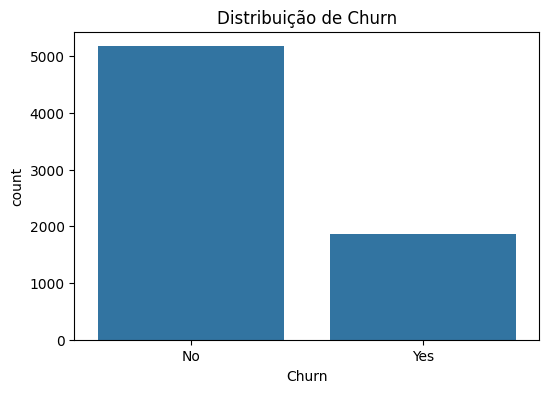

In [41]:
# Verificar a distribuição da variável alvo (Churn)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Distribuição de Churn')
plt.show()

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

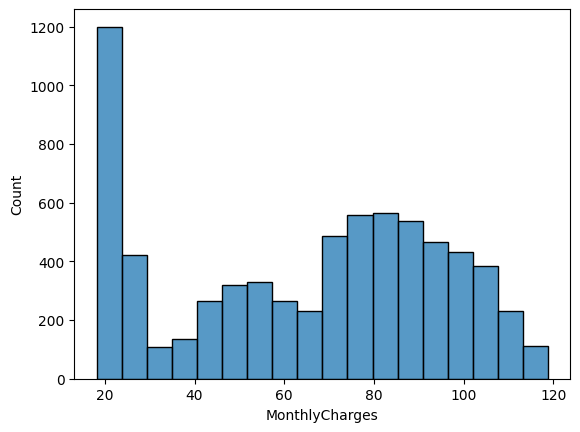

In [42]:
sns.histplot(df['MonthlyCharges'])  # Numérica: curva contínua
#sns.countplot(x=df['Contract'])    # Categórica: poucas barras

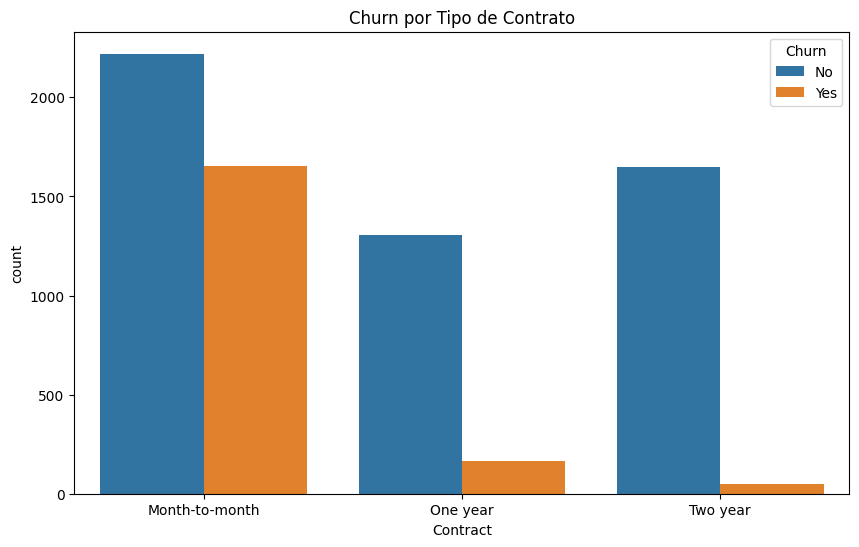

In [43]:
# Verificar o Churn por tipo de contrato
#Mensal x anual x longo
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn por Tipo de Contrato')
plt.show()

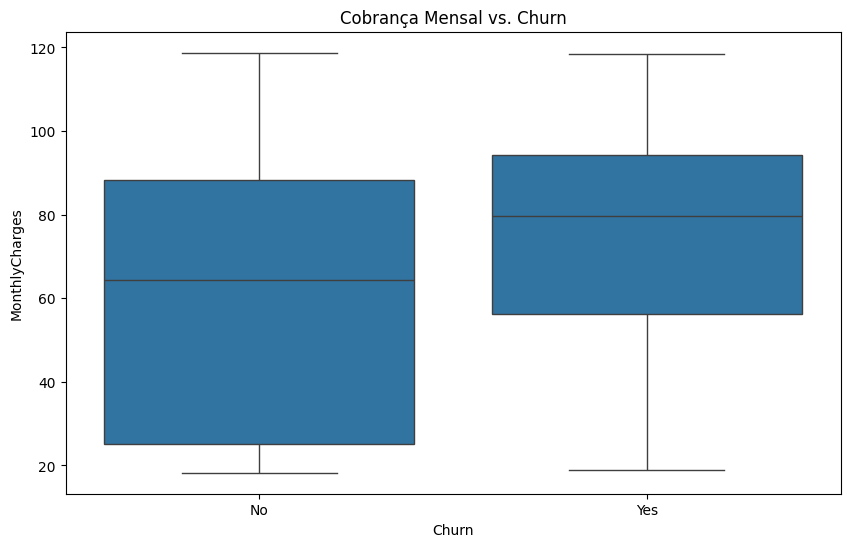

In [44]:
# Explorar variáveis numéricas
#Mensal vs 
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Cobrança Mensal vs. Churn')
plt.show()

In [45]:
colunas = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']
df_teste = df[colunas]

df_teste['Churn'] = df_teste['Churn'].map({'Yes': 1, 'No': 0})

df_teste.head()

# Converter TotalCharges para float (tem espaços em branco)
df_teste['TotalCharges'] = pd.to_numeric(df_teste['TotalCharges'], errors='coerce')

# Verificar valores ausentes
print("Valores ausentes em df_teste:")
print(df_teste.isnull().sum())

# Tratar valores ausentes (preencher TotalCharges com a média) da partir da função fillna
#df_teste['TotalCharges'] = df_teste['TotalCharges'].fillna(df_teste['TotalCharges'].max())

Valores ausentes em df_teste:
Churn              0
tenure             0
MonthlyCharges     0
TotalCharges      11
dtype: int64


C:\Users\Matheus\AppData\Local\Temp\ipykernel_21932\3873578555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['Churn'] = df_teste['Churn'].map({'Yes': 1, 'No': 0})
C:\Users\Matheus\AppData\Local\Temp\ipykernel_21932\3873578555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['TotalCharges'] = pd.to_numeric(df_teste['TotalCharges'], errors='coerce')


In [46]:
# corr vai medir a relação linear entre duas variáveis numéricas
df_teste.corr()

,Churn,tenure,MonthlyCharges,TotalCharges
Churn,1.000000,-0.352229,0.193356,-0.199484
tenure,-0.352229,1.000000,0.247900,0.825880
MonthlyCharges,0.193356,0.247900,1.000000,0.651065
TotalCharges,-0.199484,0.825880,0.651065,1.000000


In [47]:
# --- 2. Pré-processamento ---
# Remover a coluna customerID (não é útil para o modelo)
#df = df.drop('customerID', axis=1)

# Converter TotalCharges para float (tem espaços em branco)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Separar features (X) e alvo (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})  # Converter Yes/No para 1/0


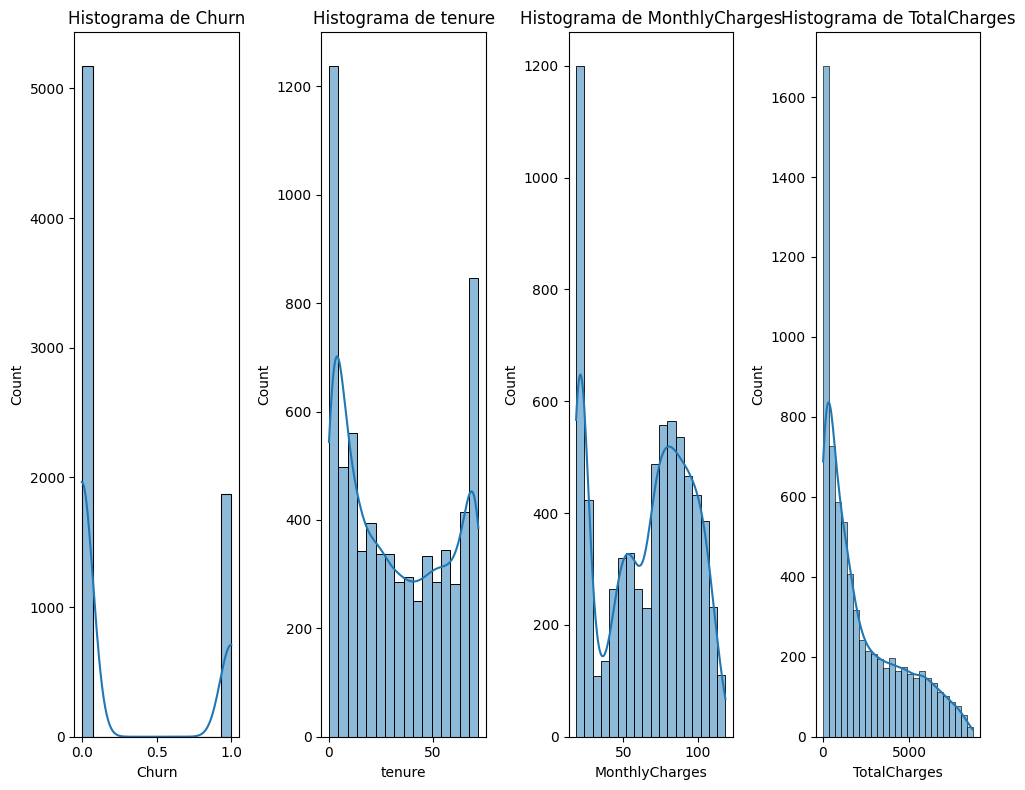

In [48]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(colunas, 1):
    plt.subplot(1, 4, i)
    sns.histplot(df_teste[col], kde=True)
    plt.title(f'Histograma de {col}')
plt.tight_layout()
plt.show()


In [49]:
# Função para calcular limites e contar outliers
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return lower_bound, upper_bound, outliers

# Analisar outliers
for col in colunas:
    lower, upper, outliers = detect_outliers(df_teste[col])
    print(f"\n{col}:")
    print(f"Limite inferior: {lower:.2f}, Limite superior: {upper:.2f}")
    print(f"Número de outliers: {len(outliers)}")
    if len(outliers) > 0:
        print(f"Exemplos de outliers: {outliers.head().values}")

# Não há necessidade de tratamento dos outliers, pois não foi detectado nenhum. 


Churn:
Limite inferior: -1.50, Limite superior: 2.50
Número de outliers: 0

tenure:
Limite inferior: -60.00, Limite superior: 124.00
Número de outliers: 0

MonthlyCharges:
Limite inferior: -46.02, Limite superior: 171.38
Número de outliers: 0

TotalCharges:
Limite inferior: -4688.48, Limite superior: 8884.67
Número de outliers: 0


In [58]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar colunas numéricas e categóricas
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = [col for col in X.columns if col not in numeric_cols]

# Criar transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Preencher ausentes com média #pq preencher com a média ?
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Preencher com a moda 
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_cols)
    ])


Resultados dos Modelos:

Distribuição após SMOTE para Random Forest (treino):
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64
Random Forest:
  Acurácia: 0.80
  Relatório de Classificação:
              precision    recall  f1-score   support

    No Churn       0.85      0.89      0.87      1036
       Churn       0.65      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



c:\Users\Matheus\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


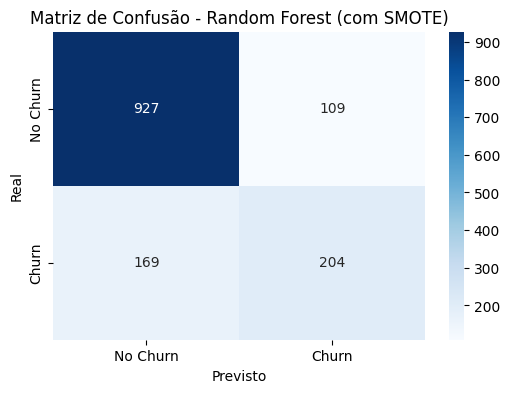

In [60]:
# --- 3. Criar Pipelines com Dois Modelos ---
modelos = {
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42) #Para datasets de tamanho médio, como o Telco (~7.000 linhas), 100 árvores são suficientes para capturar padrões sem overfitting excessivo.
}

pipelines = {}
for nome, modelo in modelos.items():
    pipeline = ImbPipeline(steps=[
        ('preprocessamento', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('modelo', modelo)
    ])
    pipelines[nome] = pipeline

# --- 4. Treinar e Avaliar ---
print("\nResultados dos Modelos:\n")
for nome, pipeline in pipelines.items():
    # Treinar
    pipeline.fit(X_train, y_train)

    # Verificar balanceamento após SMOTE (no treino)
    X_train_transformed, y_train_transformed = pipeline.named_steps['smote'].fit_resample(
        pipeline.named_steps['preprocessamento'].fit_transform(X_train), y_train
    )
    print(f"Distribuição após SMOTE para {nome} (treino):")
    print(pd.Series(y_train_transformed).value_counts(normalize=True))

    # Prever
    y_pred = pipeline.predict(X_test)
    
    # Avaliar
    acuracia = accuracy_score(y_test, y_pred)
    print(f"{nome}:")
    print(f"  Acurácia: {acuracia:.2f}")
    print("  Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], 
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Matriz de Confusão - {nome} (com SMOTE)')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

In [52]:
classifier = pipeline.named_steps['modelo']

feature_importances = classifier.feature_importances_

all_features = numeric_cols + categorical_cols

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importances
})

feature_importance_df.sort_values(by='importance', ascending=False)

ValueError: All arrays must be of the same length

In [ ]:
# --- 5. Previsão para Novo Cliente ---
novo_cliente = pd.DataFrame({
    'gender': ['Female'],
    'SeniorCitizen': [0],
    'Partner': ['Yes'],
    'Dependents': ['No'],
    'tenure': [12],
    'PhoneService': ['Yes'],
    'MultipleLines': ['No'],
    'InternetService': ['DSL'],
    'OnlineSecurity': ['No'],
    'OnlineBackup': ['Yes'],
    'DeviceProtection': ['No'],
    'TechSupport': ['No'],
    'StreamingTV': ['No'],
    'StreamingMovies': ['No'],
    'Contract': ['Month-to-month'],
    'PaperlessBilling': ['Yes'],
    'PaymentMethod': ['Electronic check'],
    'MonthlyCharges': [60.0],
    'TotalCharges': [720.0]
})

print("\nPrevisão para Novo Cliente:\n")
for nome, pipeline in pipelines.items():
    resultado = pipeline.predict(novo_cliente)
    prob = pipeline.predict_proba(novo_cliente)[0]
    print(f"{nome}:")
    print(f"  Previsão: {'Churn' if resultado[0] == 1 else 'No Churn'}")
    print(f"  Probabilidades: No Churn={prob[0]:.2f}, Churn={prob[1]:.2f}\n")


Previsão para Novo Cliente:

Random Forest:
  Previsão: No Churn
  Probabilidades: No Churn=0.80, Churn=0.20

Logistic Regression:
  Previsão: Churn
  Probabilidades: No Churn=0.41, Churn=0.59

